In [6]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers, mixed_precision
from tensorflow.keras.layers import ReLU, RandomContrast, RandomTranslation, RandomFlip, RandomRotation, Input, LeakyReLU, Conv2D, Activation, MaxPool2D, Flatten, Dense, Reshape, Conv2DTranspose, UpSampling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import Callback
from pathlib import Path
import os
import pathlib
import time
import datetime
from matplotlib import pyplot as plt
import cv2 #pip install opencv-python
import numpy as np
from glob import glob 
from tensorflow.keras import backend as K
from contextlib import redirect_stdout
from tensorflow.keras.models import Model
import time
import random


PATH = 'G:/Deletar/pictures_conv'
tf.random.set_seed(42) 
PRECISION = tf.float32
HEIGHT = 512
WIDTH = 512
FILTERS = 128
KERNEL_SIZE = 3
STRIDES = 1
BATCH = 1
OUTPUT_CHANNELS = 3
BUFFER_SIZE = 4
IMG_RANGE = 255.
PC = 1
IMAGES_TRAINING_SIZE = 100
IMAGES_TESTING_SIZE = 10
EPOCHS = 1
EPOCHS_PRINT = 25
MAX_LOOPS = 0 # if zero = max possible
OUTER_LOOPS = 1

def get_all_info(folder):    
    imgs = []
    for file in os.listdir(folder):
        imgs.append(folder+file)
    return imgs

def split(arr, size):
    arrs = []
    while len(arr) > size:
        pice = arr[:size]
        arrs.append(pice)
        arr   = arr[size:]
    arrs.append(arr)
    return arrs

if (PC != 1):
    train_bw = get_all_info("C:\\Deletar\\pictures_conv\\train_new\\bw\\")
    train_bw = split(train_bw,IMAGES_TRAINING_SIZE)
    train_color = get_all_info("C:\\Deletar\\pictures_conv\\train_new\\color\\")
    train_color = split(train_color,IMAGES_TRAINING_SIZE)
    test_bw = get_all_info("C:\\Deletar\\pictures_conv\\test_new\\bw\\")
    test_bw = split(test_bw,IMAGES_TESTING_SIZE)
    test_color = get_all_info("C:\\Deletar\\pictures_conv\\test_new\\color\\")
    test_color = split(test_color,IMAGES_TESTING_SIZE)
    file_01 = "C:\\Deletar\\pictures_conv\\01.jpg"
    eval_imgs = glob("C:\\Deletar\\pictures_conv\\*.jpg")
else:
    train_bw = get_all_info("G:\\Deletar\\pictures_conv\\train_new\\bw\\")
    train_bw = split(train_bw,IMAGES_TRAINING_SIZE)
    train_color = get_all_info("G:\\Deletar\\pictures_conv\\train_new\\color\\")
    train_color = split(train_color,IMAGES_TRAINING_SIZE)
    test_bw = get_all_info("G:\\Deletar\\pictures_conv\\test_new\\bw\\")
    test_bw = split(test_bw,IMAGES_TESTING_SIZE)
    test_color = get_all_info("G:\\Deletar\\pictures_conv\\test_new\\color\\")
    test_color = split(test_color,IMAGES_TESTING_SIZE)
    """ train_bw = glob("G:\\Deletar\\pictures_conv\\train_new\\bw\\*.jpg")
    train_color = glob("G:\\Deletar\\pictures_conv\\train_new\\color\\*.jpg")
    test_bw = glob("G:\\Deletar\\pictures_conv\\test_new\\bw\\*.jpg")
    test_color = glob("G:\\Deletar\\pictures_conv\\test_new\\color\\*.jpg") """

    file_01 = "G:\\Deletar\\pictures_conv\\01.jpg"
    eval_imgs = glob("G:\\Deletar\\pictures_conv\\*.jpg")

if MAX_LOOPS == 0:
    MAX_LOOPS = len(train_bw)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [7]:
# apply black and white colors to image

def apply_gauss_and_sharpen(img):    
    blur = cv2.GaussianBlur(img,(5,5),0)
    kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
    image_sharp = cv2.filter2D(src=blur, ddepth=-1, kernel=kernel)
    return image_sharp

def apply_bw(filename):
    img = plt.imread(filename)
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Input IMG is RGB
    img = cv2.merge([img,img,img])
    return img

def resize_image2(data):
    resized_img = tf.image.resize(
    images=K,
    size=[HEIGHT, WIDTH],
    method=tf.image.ResizeMethod.BILINEAR,
    preserve_aspect_ratio=False,
    antialias=True,
    )    
    return resized_img

def process_img(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)    
    img = tf.image.convert_image_dtype(img, PRECISION)
    """ img = tf.image.resize(img, size=(HEIGHT, WIDTH), antialias=True,method=tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=False,) """
    return img

def process_img2(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = apply_gauss_and_sharpen(img.numpy())
    img = tf.image.convert_image_dtype(img, PRECISION)
    img = tf.image.resize(img, size=(HEIGHT, WIDTH), antialias=True,method=tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=False,)
    return img

# read img and transform into tensor image
def read_img(filename):
    img = plt.imread(filename)
    if len(img.shape) == 2:
        img = cv2.merge([img,img,img])
    img = tf.convert_to_tensor(img/IMG_RANGE, dtype=PRECISION)
    return img



""" z = get_all_info("G:\\Deletar\\pictures_conv\\train_new\\bw\\") """

""" def get_dataset(i,) """


""" print(np.array(test_color)[0][0][0][1]) """

""" print(np.array(train_color).shape)
print(np.array(test_color).flatten().flatten().flatten().shape) """

""" test_color = [num for sublist in test_color for num in sublist] """

""" train_bw = split(np.array(train_bw),IMAGES_TRAINING_SIZE)
train_color = split(np.array(train_color),IMAGES_TRAINING_SIZE)
test_bw = split(np.array(train_color),IMAGES_TESTING_SIZE)
test_color = split(np.array(test_color),IMAGES_TESTING_SIZE) """

files_ds = []

tensor_img = np.zeros([16,BATCH,WIDTH,HEIGHT,3])

cont = 0
for image in eval_imgs:
    if cont < 4:
        image = process_img2(image)
        tensor_img[cont] = tf.expand_dims(image, axis=0)
        cont = cont + 1

In [8]:
""" def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(Conv2D(filters, size, padding='same', strides=2, name='conv2d_01', kernel_initializer=initializer, use_bias=False,),)                           
    if apply_batchnorm:
      result.add(BatchNormalization())
    result.add(LeakyReLU())
    return result """
  
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(Conv2D(filters, size, padding='same', strides=2, name='conv2d_01', kernel_initializer=initializer, use_bias=False,),)                           
    if apply_batchnorm:
      result.add(BatchNormalization())
    result.add(LeakyReLU())
    return result

""" def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)
  result = Sequential()
  result.add(
    Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))
  result.add(BatchNormalization())
  if apply_dropout:
      result.add(Dropout(0.5))
  result.add(ReLU())
  return result """

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)
  result = Sequential()
  result.add(
    Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))
  result.add(BatchNormalization())
  if apply_dropout:
      result.add(Dropout(0.5))
  result.add(ReLU())
  return result

""" result.add(MaxPool2D((2, 2),  padding='same')) """

class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, x_test):
        self.model = model
    
    def on_epoch_end(self, epoch, logs={}, ):
      """ if EPOCHS_PRINT -1 == epoch: """
      example2 = list(files_ds.as_numpy_iterator())
      """ img_pred = self.model.predict(tensor_img) """
      img_pred0 = self.model.predict(tensor_img[0])
      img_pred1 = self.model.predict(tensor_img[1])
      img_pred2 = self.model.predict(tensor_img[2])
      img_pred3 = self.model.predict(tensor_img[3])
      test_img_pred = (self.model.predict(example2[0][0]))[0]
      f, axarr = plt.subplots(1,6, figsize=(15, 7), constrained_layout=True, sharex=True, sharey=True)
      axarr[0].imshow(example2[0][1][0])
      axarr[1].imshow(test_img_pred)
      """ axarr[0,2].imshow(img_pred[0])
        axarr[1,0].imshow(img_pred[1])
        axarr[1,1].imshow(img_pred[2])
        axarr[1,2].imshow(img_pred[3])  """
      axarr[2].imshow(img_pred0[0])
      axarr[3].imshow(img_pred1[0])
      axarr[4].imshow(img_pred2[0])
      axarr[5].imshow(img_pred3[0]) 
      plt.show()
        
        
      """ z = self.model.predict(example[0][0])
        plt.imshow(z[0])
        plt.show() """
        

In [9]:
initializer = tf.random_normal_initializer(0., 0.02)

# improvements
# insert layer kernel_regularizer='l1'
# insert layer kernel_regularizer='l2'

# model = model = 
# model.trainable = False

""" inputs = layers.Input(shape=(HEIGHT, WIDTH, 3))
x = inputs
x = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")
x.trainable = False """

""" x = downsample(64,4, apply_batchnorm=False)(model.output) """

""" x = downsample(64,4, apply_batchnorm=False)(x)

model= x """
inputS=(HEIGHT, WIDTH, 3,)
model = Sequential()

""" model.add(Input(shape=(HEIGHT, WIDTH, 3,))) """
""" model.add(EfficientNetB0(input_shape=inputS, include_top=False, weights="imagenet")) """


""" for layer in model.layers:
  layer.trainable=False """

""" model.add(EfficientNetB0(input_shape=inputS, include_top=False, weights=None,))  """





#Encoder
""" model.add(downsample(64,4, apply_batchnorm=False))
model.add(downsample(128,4)) """

""" model.add(downsample(512,4, apply_batchnorm=False))
model.add(downsample(512,4))
model.add(downsample(512,4)) """
""" model.add(downsample(256,4, apply_batchnorm=False))
model.add(downsample(256,4)) """


""" model.add(downsample(1024,4, apply_batchnorm=False)) #best """

model.add(downsample(512,4, apply_batchnorm=False))
model.add(downsample(1024,4))



#Decoder
""" model.add(upsample(512,4, apply_dropout=True))
model.add(upsample(512,4, apply_dropout=True)) """

""" model.add(upsample(256,4, apply_dropout=True)) """


""" model.add(Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer))
model.add(Activation('tanh'))  """


""" model.add(Activation('tanh')) """
""" model.add(Activation('sigmoid')) """


""" model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(3, (3, 3), activation='tanh', padding='same')) """


model.add(upsample(512,4, apply_dropout=True))



""" model.add(upsample(64,4))
model.add(upsample(32,4)) """
""" model.add(Activation('sigmoid')) """

model.add(Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                          strides=2,
                                          padding='same',
                                          kernel_initializer=initializer,
                                          activation='sigmoid',
                                          ))

model.compile(
    # loss
    # loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    # loss=tf.keras.losses.BinaryCrossentropy(),
    # loss=tf.keras.losses.MeanSquaredError(),
    loss=tf.keras.losses.MeanSquaredError(),

    # optimizer     
    #optimizer= tf.keras.optimizers.Adam(2e-3, beta_1=0.5),
    # optimizer= tf.keras.optimizers.RMSprop(),

    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(tf.keras.optimizers.Adam(learning_rate=5e-4)),
    metrics=["accuracy"]    
)


0%
0
None of 1
100/100 [==============================] - 77s 758ms/step - loss: 0.0277 - accuracy: 0.4009 - val_loss: 0.0375 - val_accuracy: 0.4293


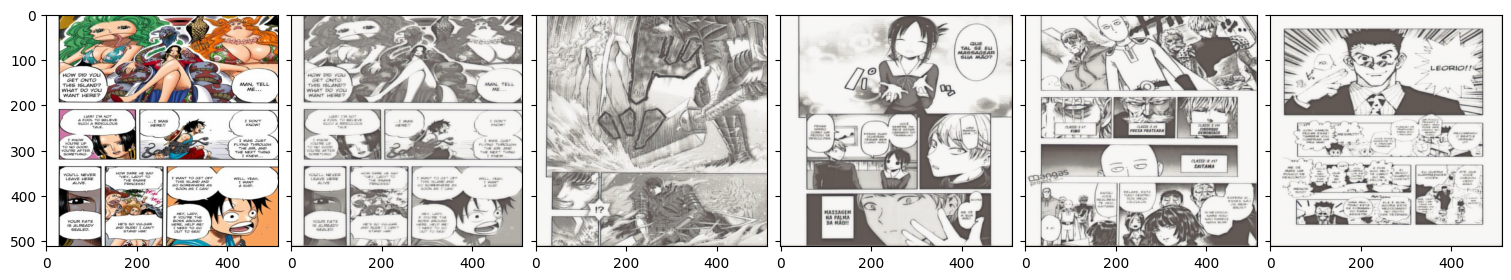

0.1597444089456869% - 1975s
........

In [10]:
""" callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True) """
""" callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=9999, restore_best_weights=True) """

""" model.fit(files_ds,epochs=100, callbacks=[CustomCallback(model, files_ds), callback], validation_data=val_files) """
cont_outer = 0
print('0%')
for j in range(OUTER_LOOPS):
    print(f"{print(cont_outer)} of {OUTER_LOOPS}")
    for i in range(len(train_bw)):
        if i < MAX_LOOPS:                        
            files_ds = tf.data.Dataset.from_tensor_slices((train_bw[i], train_color[i]))
            files_ds = files_ds.map(lambda x, y: (process_img(x), process_img(y))).batch(BATCH).shuffle(BUFFER_SIZE)
            val_files = tf.data.Dataset.from_tensor_slices((test_bw[i], test_color[i]))
            val_files = val_files.map(lambda x, y: (process_img(x), process_img(y))).batch(BATCH)
            if cont_outer % EPOCHS_PRINT == 0:  
                start = time.time()              
                model.fit(files_ds,epochs=EPOCHS, callbacks=[CustomCallback(model, files_ds)], validation_data=val_files, verbose=1)
                end = time.time()
                print(f"{(cont_outer+1)/len(train_bw)*100/OUTER_LOOPS}% - {int(end-start)*EPOCHS_PRINT}s")
            else:
                model.fit(files_ds,epochs=EPOCHS, verbose=0)
                print(".", end = '')            
            cont_outer = cont_outer + 1
    



            

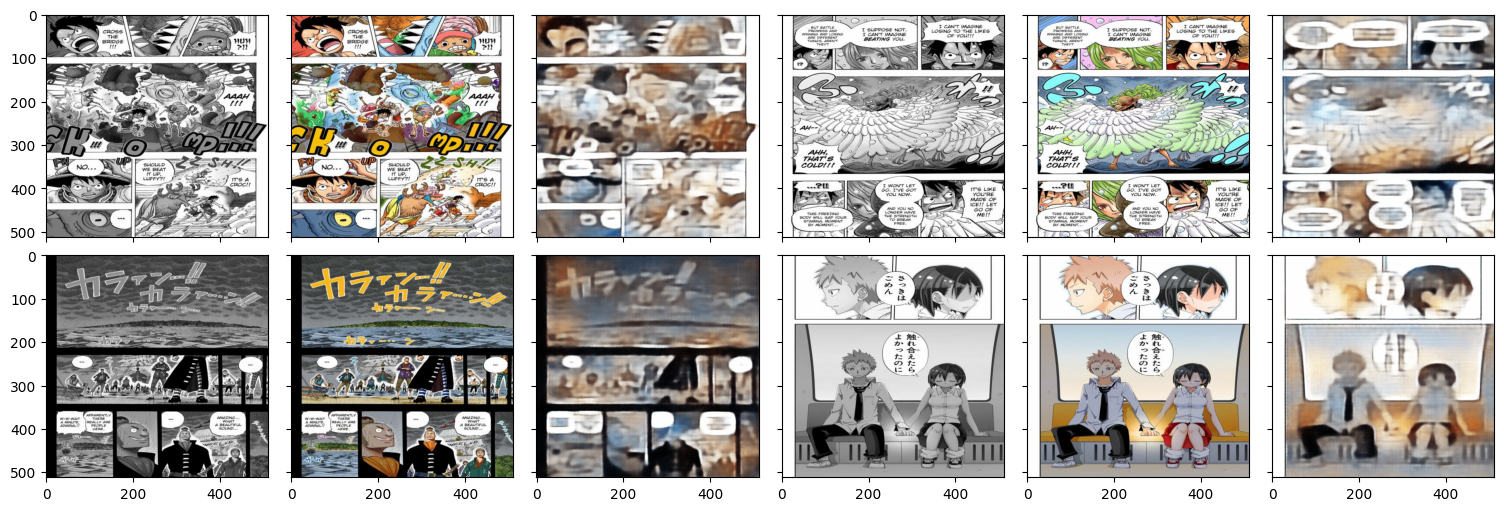

In [ ]:
example = list(files_ds.as_numpy_iterator())
example2 = list(val_files.as_numpy_iterator())

r_img1 = random.randint(0, len(example2)-1)
r_img2 = random.randint(0, len(example2)-1)
r_img3 = random.randint(0, len(example2)-1)
r_img4 = random.randint(0, len(example)-1)

test_img_pred = model.predict(example2[r_img1][0])[0]
test_img_pred2 = model.predict(example2[r_img2][0])[0]
test_img_pred3 = model.predict(example2[r_img3][0])[0]
train_img_pred = model.predict(example[r_img4][0])[0]

f, axarr = plt.subplots(2,6, figsize=(15, 5), constrained_layout=True, sharex=True, sharey=True)
axarr[0,0].imshow(example2[r_img1][0][0])
axarr[0,1].imshow(example2[r_img1][1][0])
axarr[0,2].imshow(test_img_pred)
axarr[0,3].imshow(example2[r_img2][0][0])
axarr[0,4].imshow(example2[r_img2][1][0])
axarr[0,5].imshow(test_img_pred2)

axarr[1,0].imshow(example2[r_img3][0][0])
axarr[1,1].imshow(example2[r_img3][1][0])
axarr[1,2].imshow(test_img_pred3)
axarr[1,3].imshow(example[r_img4][0][0])
axarr[1,4].imshow(example[r_img4][1][0])
axarr[1,5].imshow(train_img_pred)



In [ ]:
#comments

""" model = Sequential([
    Conv2D(FILTERS, (3, 3),  padding='same', name='conv2d_01'),
    LeakyReLU(),
    MaxPool2D((2, 2),  padding='same', name='max_pool_01'),
    Conv2D(FILTERS/2, (3, 3),  padding='same', name='conv2d_02'),
    BatchNormalization(),
    LeakyReLU(),
    MaxPool2D((2, 2),  padding='same', name='max_pool_02'),
    Conv2D(FILTERS/4, (3, 3),  padding='same', name='conv2d_03'),
    BatchNormalization(),
    LeakyReLU(),
    MaxPool2D((2, 2),  padding='same', name='max_pool_04'),
    Conv2D(FILTERS/4, (3, 3),  padding='same', name='conv2d_04'),
    Dropout(0.5),
    Activation('relu', name='relu_04'),
    UpSampling2D((2, 2)),
    Conv2D(FILTERS/2, (3, 3),  padding='same', name='conv2d_05'),
    Dropout(0.5),
    Activation('relu', name='relu_05'),
    UpSampling2D((2, 2)),
    Conv2D(FILTERS, (3, 3),  padding='same', name='conv2d_06'),
    Activation('relu', name='relu_06'),
    UpSampling2D((2, 2)),
    Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=1,
                                         padding='same'),
    Activation('tanh'),    
]) """

# model.add(Input(shape=[HEIGHT, WIDTH, 3]))

""" model.add(downsample(128,4, apply_batchnorm=False))
model.add(upsample(128,4, apply_dropout=True)) """

""" model = Sequential()
model.add(downsample(64,9, apply_batchnorm=False))
model.add(downsample(128,4))
model.add(upsample(128,4, apply_dropout=True))
model.add(Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer))
model.add(Activation('tanh')) """

""" model.add(downsample(128,4)) """
""" model.add(downsample(256,4)) """
""" model.add(downsample(128,4, apply_batchnorm=False))
model.add(downsample(128,4))
model.add(downsample(128,4)) """
""" model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2))) """

""" model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer))
model.add(Activation('tanh')) """


""" model.add(upsample(128,4, apply_dropout=True))
model.add(upsample(128,4, apply_dropout=True)) """
""" model.add(upsample(128,4))
model.add(upsample(128,4)) """
""" model.add(upsample(256,4, apply_dropout=True)) """
""" model.add(upsample(128,4)) """


""" 
model.add(UpSampling2D((2, 2))) """

""" encoder_output = (encoder_input)



decoder_output = (encoder_output)
decoder_output = (decoder_output)
decoder_output = (decoder_output)
decoder_output = (decoder_output)
decoder_output = (decoder_output)
decoder_output = (decoder_output)
decoder_output = (decoder_output)
decoder_output = (decoder_output) """


' encoder_output = (encoder_input)\n\n\n\ndecoder_output = (encoder_output)\ndecoder_output = (decoder_output)\ndecoder_output = (decoder_output)\ndecoder_output = (decoder_output)\ndecoder_output = (decoder_output)\ndecoder_output = (decoder_output)\ndecoder_output = (decoder_output)\ndecoder_output = (decoder_output) '